In [416]:
import bioread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
from datetime import datetime
import os

In [417]:
def read_acq_file(file_path):
    recording = bioread.read_file(file_path)
    data_dict = {}

    # Assuming all channels have the same sampling rate
    samples_per_second = recording.channels[0].samples_per_second
    numsamples = len(recording.channels[0].data)

    # Create time column based on the sampling rate
    mytimecol = [(n / samples_per_second) for n in range(numsamples)]
    data_dict["Channel_6"] = mytimecol  # Time axis

    for i, channel in enumerate(recording.channels):
        data_dict[f"Channel_{i + 1}"] = channel.data

    df = pd.DataFrame(data_dict)
    return recording, df


In [418]:
def find_trigger_points(trigger_column, threshold):
    trigger_diff = (trigger_column > threshold).astype(int).diff()
    start_points = trigger_diff[trigger_diff == 1].index
    return start_points

In [419]:
def butter_highpass_filter(data, cutoff_frequency, fs, order=1):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

In [420]:
def find_highest_negative_amplitude(cropped_df, selected_channel):
   # Find the index of the maximum amplitude in the positive direction
    max_amplitude_index = cropped_df[selected_channel].idxmax()
    # Find the index of the maximum amplitude in the negative direction
    min_amplitude_index = cropped_df[selected_channel].idxmin()
    
    # Get the time and value of the maximum positive amplitude
    time_of_max_amplitude = cropped_df.loc[max_amplitude_index, "Channel_6"]
    max_amplitude_value = cropped_df[selected_channel].max()
    
    # Get the time and value of the maximum negative amplitude
    time_of_min_amplitude = cropped_df.loc[min_amplitude_index, "Channel_6"]
    min_amplitude_value = cropped_df[selected_channel].min()
    
    # Compare the absolute values to determine the highest amplitude
    if abs(max_amplitude_value) >= abs(min_amplitude_value):
        return time_of_max_amplitude, max_amplitude_value
    else:
        return time_of_min_amplitude, min_amplitude_value

In [421]:
def find_first_positive_peak_after_negative(cropped_df, selected_channel, start_time):
   # Extract data after start_time to find the first peak.
    window_data = cropped_df[cropped_df['Channel_6'] >= start_time]
    
    # Using `find_peaks` with the distance parameter ensures we are getting separate peaks.
    # We can find negative peaks by inverting the data and using the same function.
    positive_peaks_indices = find_peaks(window_data[selected_channel])[0]
    negative_peaks_indices = find_peaks(-window_data[selected_channel])[0]

    # Combine and sort indices of all peaks
    all_peaks_indices = np.sort(np.concatenate((positive_peaks_indices, negative_peaks_indices)))

    # Find the index of the first peak after the spike
    if len(all_peaks_indices) > 0:
        first_peak_index = all_peaks_indices[0]
        time_of_peak = window_data.iloc[first_peak_index]['Channel_6']
        peak_value = window_data.iloc[first_peak_index][selected_channel]
        return time_of_peak, peak_value, first_peak_index

    # Return None if no peaks are found after the spike
    return None, None, None

In [422]:
def mark_peaks_after_positive(cropped_df, selected_channel, positive_peak_index, time_of_positive_peak, save_image=False, image_base_path='CSP'):
    # Use the time_of_positive_peak directly for comparison
    post_peak_data = cropped_df[cropped_df['Channel_6'] >= time_of_positive_peak]

    if not post_peak_data.empty:
        data_for_peaks = post_peak_data[selected_channel].to_numpy().flatten()

        peaks, _ = find_peaks(data_for_peaks, prominence=0.1)
        troughs, _ = find_peaks(-data_for_peaks, prominence=0.1)

        peaks_indices = post_peak_data.iloc[peaks].index
        troughs_indices = post_peak_data.iloc[troughs].index

        env_upper = interp1d(post_peak_data['Channel_6'].iloc[peaks], data_for_peaks[peaks], kind='linear', bounds_error=False, fill_value='extrapolate')
        env_lower = interp1d(post_peak_data['Channel_6'].iloc[troughs], data_for_peaks[troughs], kind='linear', bounds_error=False, fill_value='extrapolate')

        env_time = np.linspace(post_peak_data['Channel_6'].iloc[0], post_peak_data['Channel_6'].iloc[-1], num=len(post_peak_data['Channel_6']))
        
        #Functionality added in order to zoom in on the CSP
        plt.figure(figsize=(10, 6))
        plt.plot(post_peak_data['Channel_6'], data_for_peaks, label='Data', linestyle='-', linewidth=2)
        #Envelopes Idea didn't pan out
       # plt.plot(env_time, env_upper(env_time), label='Upper Envelope', linestyle=':', linewidth=2, marker='o', markevery=5, markersize=4)
        #plt.plot(env_time, env_lower(env_time), label='Lower Envelope', linestyle='--', linewidth=2, marker='s', markevery=5, markersize=4)
        plt.plot(post_peak_data['Channel_6'].iloc[peaks], data_for_peaks[peaks], "o", color='orange', label='Peaks', markersize=10)
        plt.plot(post_peak_data['Channel_6'].iloc[troughs], data_for_peaks[troughs], "x", color='purple', label='Troughs', markersize=10)

        plt.title(f"Peaks and Troughs in {selected_channel} After Positive Peak at Time {time_of_positive_peak}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.legend()

        if save_image:
            image_path = f"{image_base_path}.jpg"
            plt.savefig(image_path, dpi=600, bbox_inches='tight')
            print(f'Plot saved as {image_path}')

        plt.show()

        return peaks_indices, troughs_indices
    else:
        plt.figure(figsize=(10, 6))
        plt.title(f"No Data in {selected_channel} After Positive Peak at Time {time_of_positive_peak}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()
        return [], []


In [423]:
def crop_array_based_on_trigger(df, trigger_index, time_window=0.1):
    samples_per_second = 1 / (df["Channel_6"].iloc[1] - df["Channel_6"].iloc[0])
    window_samples = int(time_window * samples_per_second)
    
    # Calculate the number of samples that represent one quarter of the time window
    one_third_window_samples = int(window_samples / 4)
    
    # Adjust the start index so that the trigger point appears one quarter into the plot
    start_index = max(0, trigger_index - one_third_window_samples)
    
    # Adjust the end index to maintain the overall window size
    end_index = min(len(df), start_index + window_samples)
    
    cropped_data = df.iloc[start_index:end_index]
    return cropped_data


In [424]:
def combined_plotting_function_v3(df, selected_channel, trigger_column_name, threshold, time_window=0.1, save_image=False, image_path='CSP', time_ranges=None):
    """
    Extends combined_plotting_function_v2 with the ability to plot specific time ranges.
    
    Parameters:
    - df: DataFrame containing the data.
    - selected_channels: List of channels to plot.
    - trigger_column_name: Name of the column used to find trigger points.
    - threshold: Threshold value to identify triggers.
    - time_window: Time window for cropping data around trigger points.
    - save_image: Boolean indicating whether to save plots as images.
    - image_path: Base path for saving images.
    - time_ranges: Optional list of [start, end] time intervals for focused plotting. If None, uses trigger points logic.
    """
    if time_ranges:
        # Plot for specified time ranges
        for start, end in time_ranges:
            mask = (df['Channel_6'] >= start) & (df['Channel_6'] <= end)
            filtered_df = df[mask]

            for channel in selected_channel:
                plt.figure(figsize=(12, 6))
                plt.plot(filtered_df['Channel_6'], filtered_df[channel], label=channel)
                plt.title(f"{channel} Data from {start}s to {end}s")
                plt.xlabel("Time (s)")
                plt.ylabel("Amplitude")
                plt.legend()
                plt.grid(True)

                if save_image:
                    range_image_path = f"{os.path.splitext(image_path)[0]}_Range_{start}_{end}.jpg"
                    plt.savefig(range_image_path, dpi=600, bbox_inches='tight')
                    print(f"Plot saved as {range_image_path}")

                plt.show()
    else:
        # Original functionality based on trigger points
        trigger_indices = find_trigger_points(df[trigger_column_name], threshold)
        
        for i, trigger_index in enumerate(trigger_indices):
            cropped_df = crop_array_based_on_trigger(df, trigger_index, time_window)
            trigger_time = df["Channel_6"].iloc[trigger_index]

            time_of_min_amplitude, _ = find_highest_negative_amplitude(cropped_df, selected_channel[0])
            time_of_positive_peak, _, positive_peak_index = find_first_positive_peak_after_negative(cropped_df, selected_channel[0], time_of_min_amplitude)
            
            image_base_path = f"{os.path.splitext(image_path)[0]}_{i+1}_Zoomed"
            peaks_indices, troughs_indices = mark_peaks_after_positive(cropped_df, selected_channel[0], positive_peak_index, time_of_positive_peak, save_image=True, image_base_path=image_base_path)

            plt.figure(figsize=(12, 6))
            plt.plot(cropped_df["Channel_6"], cropped_df[selected_channel[0]], label=selected_channel[0])
            plt.axvline(x=trigger_time, color='black', linestyle='--', label=f'Trigger Point: {trigger_time:.2f} s')
            plt.axvline(x=time_of_min_amplitude, color='red', linestyle='-.', label=f'RSR Spike: {time_of_min_amplitude:.2f} s')
            plt.axvline(x=time_of_positive_peak, color='green', linestyle=':', label=f'First Positive Peak at {time_of_positive_peak:.2f} s')
            plt.plot(cropped_df.loc[peaks_indices, "Channel_6"], cropped_df.loc[peaks_indices, selected_channel[0]], "o", color='orange', label='Peaks')
            plt.plot(cropped_df.loc[troughs_indices, "Channel_6"], cropped_df.loc[troughs_indices, selected_channel[0]], "x", color='purple', label='Troughs')
            plt.xlabel('Time (s)')
            plt.grid(True)
            plt.ylabel('Amplitude')
            plt.title(f'Trigger Event Analysis for Trigger at {trigger_time:.2f} s')
            plt.legend()

            if save_image:
                overall_image_path = f"{os.path.splitext(image_path)[0]}_{i+1}.jpg"
                plt.savefig(overall_image_path, dpi=600, bbox_inches='tight')
                print(f'Overall plot saved as {overall_image_path}')
            
            plt.show()

Plot saved as CSP_1_Zoomed.jpg


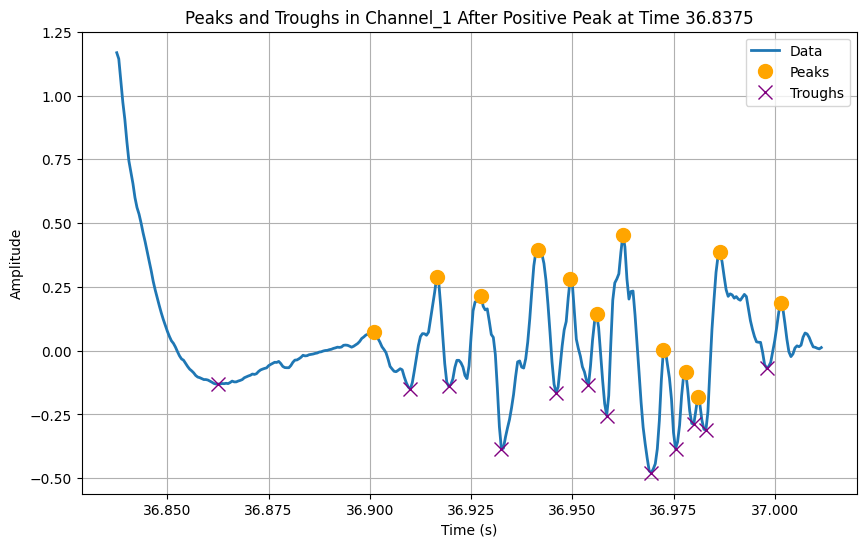

Overall plot saved as CSP_1.jpg


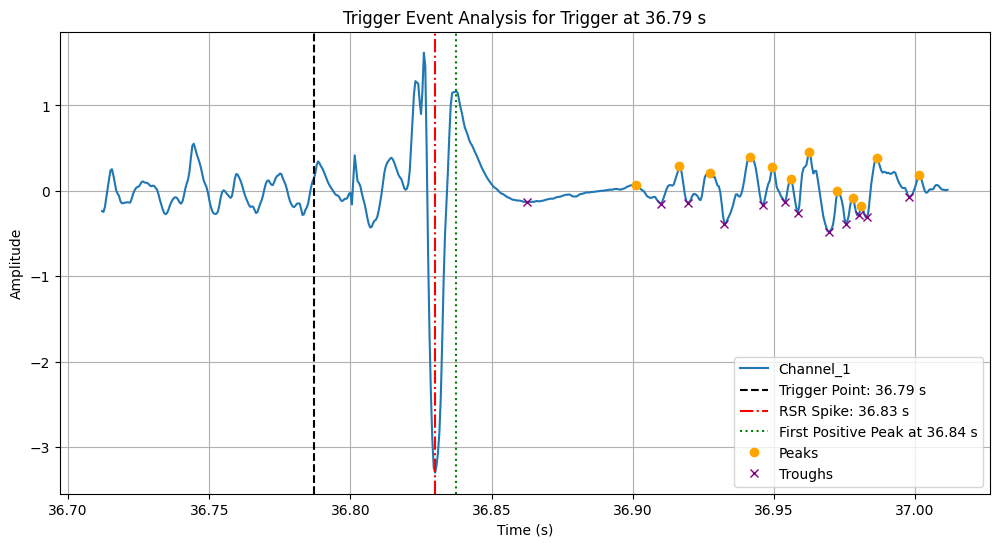

Plot saved as CSP_2_Zoomed.jpg


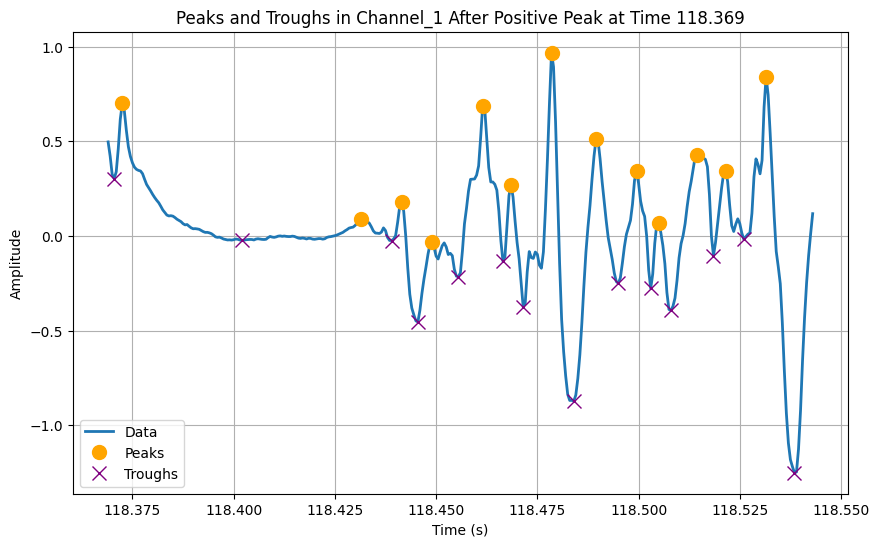

Overall plot saved as CSP_2.jpg


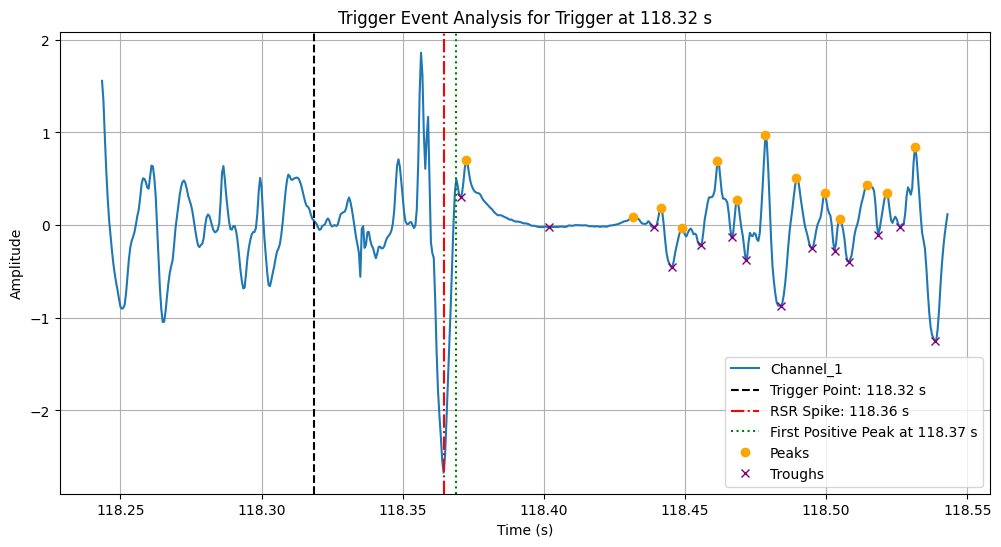

Plot saved as CSP_3_Zoomed.jpg


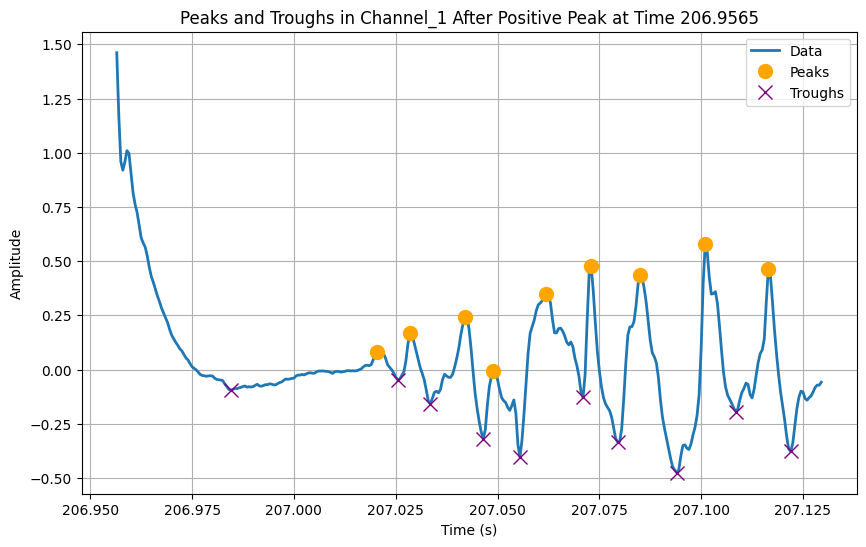

Overall plot saved as CSP_3.jpg


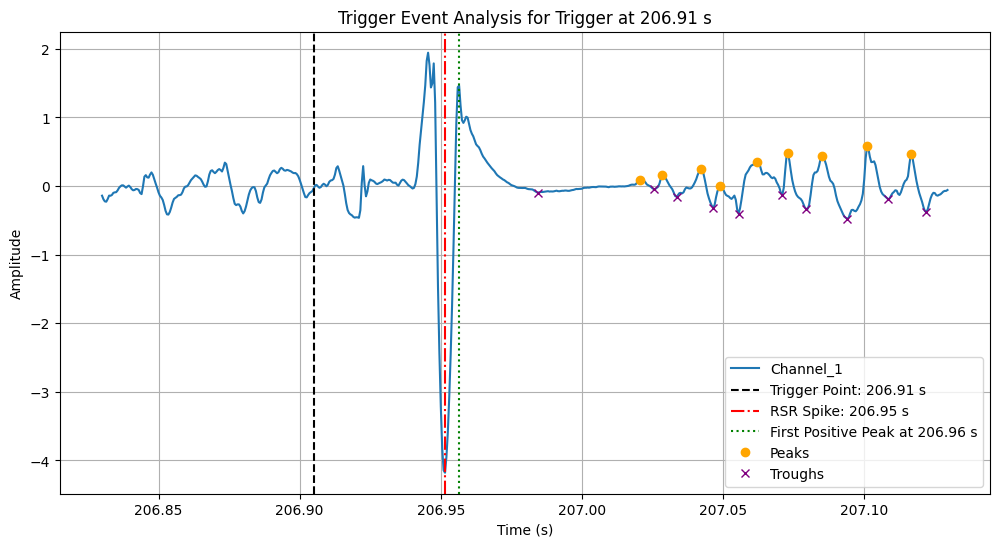

In [425]:
# Example usage
acq_file_path = "CSP_EXAMPLE.acq"
recording, df = read_acq_file(acq_file_path)
selected_channel = ["Channel_1",]
trigger_column_name = "Channel_3"
trigger_column = df[trigger_column_name]
threshold = 3.3
time_window = 0.3
image_path='CSP.jpg'

# The updated combined plotting function with the new parameters so handle the previous functions post refactoring
combined_plotting_function_v3(df=df, 
                              selected_channel=selected_channel, 
                              trigger_column_name=trigger_column_name, 
                              threshold=threshold, 
                              time_window=time_window, 
                              save_image=True, 
                              image_path=image_path)


In [426]:
import base64
import requests

# OpenAI API Key
api_key = "sk-"

from openai import OpenAI
from PIL import Image, ImageDraw, ImageFont

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Paths to csp images
image_paths = [
    "CSP_1_Zoomed.jpg",
    "CSP_1.jpg",
    "CSP_2_Zoomed.jpg",
    "CSP_2.jpg",
    "CSP_3_Zoomed.jpg",
    "CSP_3.jpg"
]

# Getting the base64 strings for each image
base64_images = [encode_image(image_path) for image_path in image_paths]

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Preparing the content array with text and images
content = [
    {
        "type": "text",
        "text": "Look at the shapes in the images provided. Be aware of times with decimal points on the x-axis. Is there a spike in the non-Zoomed in the image after a (dashed) line marked in the legend? After the spike, is there a period of flattened image compared to the rest? Provide a range of times starting from the first Dashed vertical line, including the spike, and ending at the beginning of normal wave activity after the flatline with no peaks or troughs at the end. And a statement about the length of the range in milliseconds. Only comment on a set for each trigger event if the image is being provided. When looking at the images, look for steep upwards and downward wave activity; observe both the standard version first And the zoomed-in version for greater accuracy, you should take the length from the trigger to when the line is no longer flat. Expect to find the length similar to, on average, between 100ms-130ms From The trigger line before the spike till the first normal wave after the flattened period. Create a list of each length at the end of the report labelled CSP_1, 2 and 3."


    }
]

# Adding images to the content
for base64_image in base64_images:
    content.append({
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }
    })

payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
        {
            "role": "user",
            "content": content
        }
    ],
    "max_tokens": 1000
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
print(response.json())


{'id': 'chatcmpl-9F9VGNq6OdjFNUrmMegVTLR0gv8Zz', 'object': 'chat.completion', 'created': 1713398478, 'model': 'gpt-4-1106-vision-preview', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "To determine the lengths, we'll examine the provided trigger event images and note the timestamps from the trigger points to the end of the flattened period, marking the start of normal wave activity.\n\nFor the first event:\n- Trigger Point: 36.79 seconds\n- End of flattened period: Approximately 36.91 seconds\n\nFor the second event:\n- Trigger Point: 118.32 seconds\n- End of flattened period: Approximately 118.44 seconds\n\nFor the third event:\n- Trigger Point: 206.91 seconds\n- End of flattened period: Approximately 207.03 seconds\n\nCalculating the lengths of these ranges:\n- CSP_1: 36.91 s - 36.79 s = 0.12 s (120 ms)\n- CSP_2: 118.44 s - 118.32 s = 0.12 s (120 ms)\n- CSP_3: 207.03 s - 206.91 s = 0.12 s (120 ms)\n\nTherefore, all three lengths calculated from the trigger to 

In [427]:
content = response.json()['choices'][0]['message']['content']
print(content)

To determine the lengths, we'll examine the provided trigger event images and note the timestamps from the trigger points to the end of the flattened period, marking the start of normal wave activity.

For the first event:
- Trigger Point: 36.79 seconds
- End of flattened period: Approximately 36.91 seconds

For the second event:
- Trigger Point: 118.32 seconds
- End of flattened period: Approximately 118.44 seconds

For the third event:
- Trigger Point: 206.91 seconds
- End of flattened period: Approximately 207.03 seconds

Calculating the lengths of these ranges:
- CSP_1: 36.91 s - 36.79 s = 0.12 s (120 ms)
- CSP_2: 118.44 s - 118.32 s = 0.12 s (120 ms)
- CSP_3: 207.03 s - 206.91 s = 0.12 s (120 ms)

Therefore, all three lengths calculated from the trigger to the end of the flattened period (marked by the return of normal wave activity) are 120 milliseconds each.


In [428]:
import json
import requests
import re
# Your OpenAI API Key
api_key = "sk-"

# The base URL for OpenAI API
url = "https://api.openai.com/v1/chat/completions"
previous_response_content = response.json() # Placeholder for demonstration

# Check if the 'previous_response_content' needs to be converted to a string JSON
if not isinstance(previous_response_content, str):
    previous_content = json.dumps(previous_response_content)
else:
    previous_content = previous_response_content


# The base URL for OpenAI API
url = "https://api.openai.com/v1/chat/completions"

# Setting up the payload using 'previous_content'
payload = {
    "model": "gpt-4",
    "messages": [
        {
            "role": "system",
            "content": "You will be provided with details of neural activity events. Please format the times of these events into an array format as requested: [[start1, end1], [start2, end2], [start3, end3]]."
        },
        {
            "role": "user",
            "content": f"Based on the following data, provide the times in an array format as requested: [[start1, end1], [start2, end2], [start3, end3]].\n\n{previous_content}"
        }
    ]
}

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Making the API request
response = requests.post(url, json=payload, headers=headers)

# Checking the response
if response.status_code == 200:
    print(response.json()['choices'][0]['message']['content'])
else:
    print(f"Error: {response.status_code}, {response.text}")

[[36.79, 36.91], [118.32, 118.44], [206.91, 207.03]]


In [429]:
def extract_time_ranges(response_text):
    """
    Extracts an array of time ranges from a string.
    
    Parameters:
    - response_text: The text content of the API response.
    
    Returns:
    A list of lists, where each inner list contains the start and end times as floats.
    """
    # Regular expression to find sequences of numbers, possibly including a decimal point
    matches = re.findall(r'\[\[(.*?)\]\]', response_text)
    if matches:
        # Split the first match by '], [' to separate each range, then split by ', ' to separate start and end times
        # Convert each string number to float and return the list of lists
        return [[float(n) for n in range_pair.split(', ')] for range_pair in matches[0].split('], [')]
    else:
        return []

# Making the API request
response = requests.post(url, json=payload, headers=headers)

# Checking if the request was successful
if response.status_code == 200:
    # Extract the text content from the response JSON
    api_response_text = response.json()['choices'][0]['message']['content']
else:
    print(f"Error: {response.status_code}, {response.text}")
    api_response_text = ""

# Assuming api_response_text contains the response in the expected format, now pass it to the function
time_ranges = extract_time_ranges(api_response_text)

# Display the extracted time ranges
print(time_ranges)

[[36.79, 36.91], [118.32, 118.44], [206.91, 207.03]]


Plot saved as CSP_Range_36.79_36.91.jpg


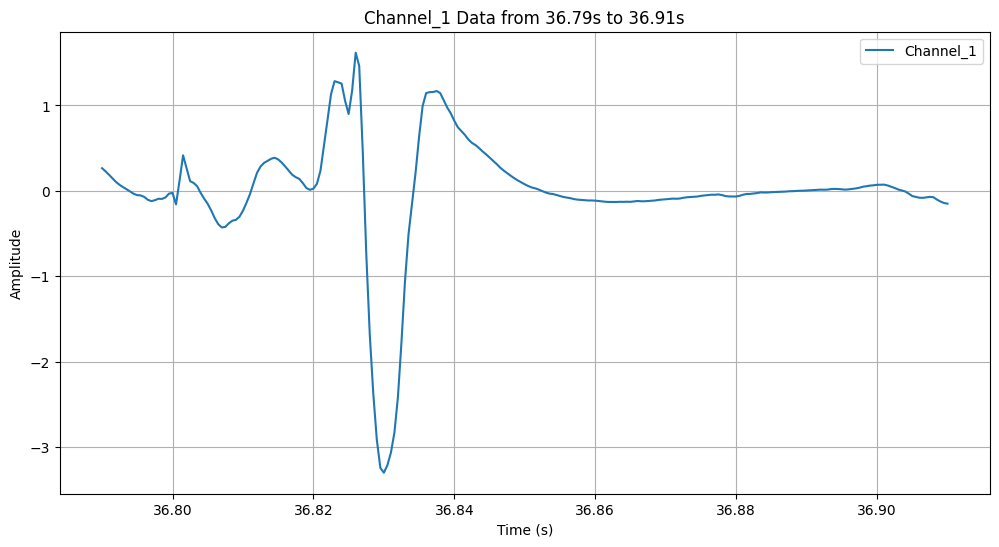

Plot saved as CSP_Range_118.32_118.44.jpg


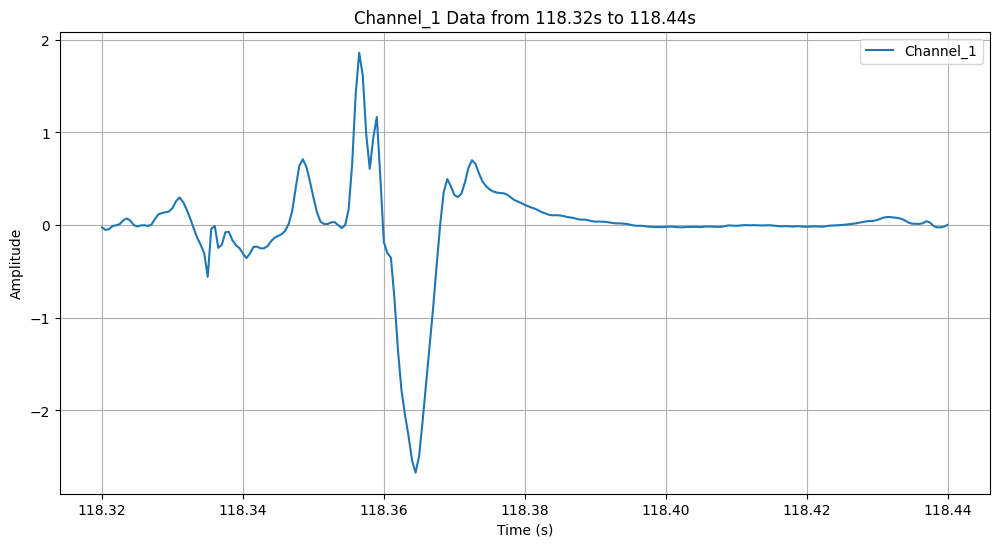

Plot saved as CSP_Range_206.91_207.03.jpg


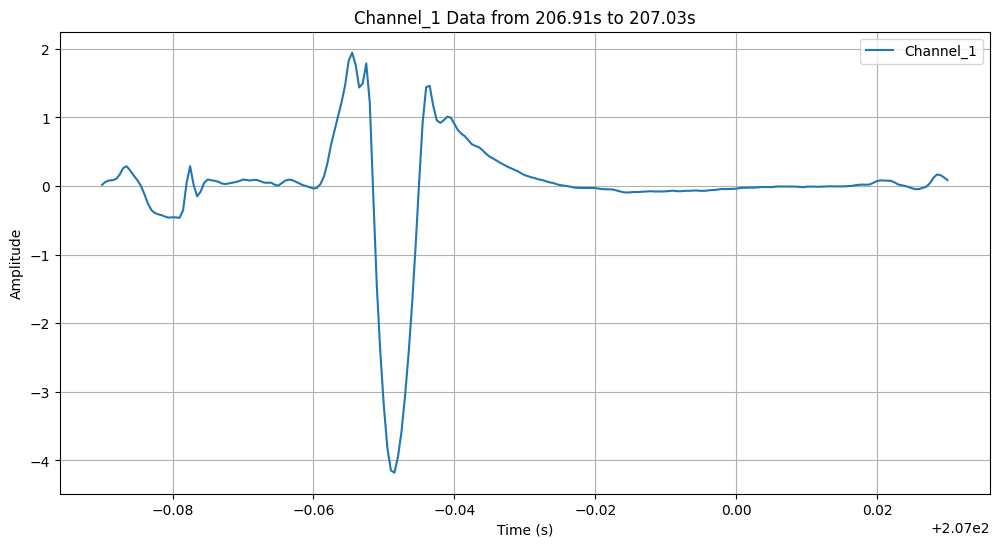

In [430]:
combined_plotting_function_v3(df, ["Channel_1"], "Channel_3", 3.3, 0.1, True, "CSP", time_ranges=time_ranges)
